## Domácí úkol: Lineární regrese pro předpověď  šance na přijetí na vysokou školu


In [81]:
# Autor: Kateřina Chmelařová
# 1. úkol Python pro datovou vědu
# Zpracovala dne 4.5.2024, úpravy 13.5.2024

In [82]:
# cíl: Vytvořte model lineární regrese, který na základě dostupných údajů předpoví šanci na přijetí na vysokou školu

In [83]:
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import iqr
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import OLSInfluence


In [85]:
data = pd.read_csv("adm_data.csv")
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [86]:
data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67


In [87]:
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [88]:
data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [89]:
data = data.rename(columns={'Serial No.':'Serial_No.', 'GRE Score':'GRE_Score', 'TOEFL Score':'TOEFL_Score', 'University Rating':'University_Rating', 'SOP':'SOP',
       'LOR ':'LOR', 'CGPA':'CGPA', 'Research':'Research', 'Chance of Admit ':'Chance_of_Admit'})
data.head()


,Serial_No.,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [90]:
data.describe()
data.shape

(400, 9)

### Normálnost dat pro TOEFL skóre

In [91]:
# 1. Vypočítejte průměr pro TOELF skóre
print(data["TOEFL_Score"].mean())

107.41


In [92]:
# Vypočítejte medián pro TOELF skóre
print(data["TOEFL_Score"].median())

107.0


In [93]:
# 2. Vypočítejte směrodatnou odchylku
std = data["TOEFL_Score"].std()
std

6.069513777374126

<AxesSubplot: xlabel='TOEFL_Score', ylabel='Count'>

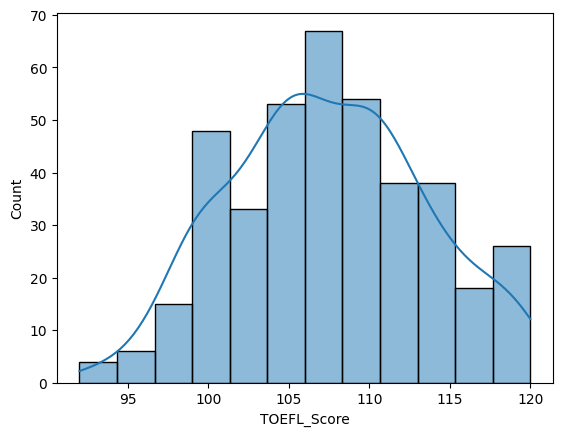

In [94]:
# 3. Vytvořte histogram pro TOEFL skóre a nezapomeňte zobrazit odhadovanou křivku pravděpodobnostního rozdělení

sns.histplot(data['TOEFL_Score'], kde=True)
# zobrazení odhadované křivky pravděpodobnostního rozdělení s parametrem kde

In [95]:
# 4. Otestujte, zda je TOEFL skóre vybráno z normálního rozdělení pomocí statistického testu. Uvažujte hladinu.
# Hypotézy pro tento test:

#H0: Data mají normální rozdělení.
#H1: Data nemají normální rozdělení.

In [96]:
stats.shapiro(data["TOEFL_Score"])

ShapiroResult(statistic=0.9873196639760413, pvalue=0.0014665094198338781)

In [97]:
# p-hodnota je statisticky významná na 5% hladině významnosti, zamítám tedy nulovou hypotézu, 
# Tvrdím, že data nemají normální rozdělení

### Testování hypotéz

In [98]:
# 1. Rozdělte data na studenty, kteří mají a nemají zkušenost s výzkumem

In [99]:
research_experienced = data[data["Research"] == 1]
research_unexperienced = data[data["Research"] == 0]

In [100]:
research_experienced

,Serial_No.,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
5,6,330,115,5,4.5,3.0,9.34,1,0.90
...,...,...,...,...,...,...,...,...,...
394,395,329,111,4,4.5,4.0,9.23,1,0.89
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91


In [101]:
research_unexperienced

,Serial_No.,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
4,5,314,103,2,2.0,3.0,8.21,0,0.65
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45
15,16,314,105,3,3.5,2.5,8.30,0,0.54
...,...,...,...,...,...,...,...,...,...
388,389,296,97,2,1.5,2.0,7.80,0,0.49
390,391,314,102,2,2.0,2.5,8.24,0,0.64
391,392,318,106,3,2.0,3.0,8.65,0,0.71
393,394,317,104,2,3.0,3.0,8.76,0,0.77


In [102]:
# 2. Pro obě skupiny spočítejte průměrné GRE skóre

In [103]:
research_experienced["GRE_Score"].mean()

322.85388127853884

In [104]:
research_unexperienced["GRE_Score"].mean()

309.49171270718233

In [105]:
# 3. Statisticky otestujte, zda existuje statisticky významný rozdíl v GRE skóre mezi těmito dvěma skupinami 
# studentů. Vyberte správný test a nezapomeňte krátce okomentovat vyhodnocení testu.

# Hypotézy
# H0: Data mají normální rozdělení.
# H1: Data nemají normální rozdělení.

# Chci tedy zjistit, zda data mají normální rozdělení
stats.shapiro(research_experienced["GRE_Score"])
# P-hodnota prvního testu je 0.00018, zamítám tedy nulovou hypotézu. Výsledek je, že data nemají normální rozdělení.

ShapiroResult(statistic=0.971098909586138, pvalue=0.0001849480132102178)

In [106]:
stats.shapiro(research_unexperienced["GRE_Score"])
# P-hodnota druhéto testu je 0.09893, nemohu tedy zamítnout nulovou hypotézu - data mají normální rozdělení

ShapiroResult(statistic=0.9871705498837187, pvalue=0.09892920318241735)

In [107]:
# Pokuď ale jeden z nich nemá normální rozdělení, musím použít Mann Whitney U test na základě:
# tj. potřebuji dvouvýběrový test (2 vzorky)
# porovnávám střední hodnotu (průměr) výběrů
# data nemají normální rozdělení
# výběry jsou nezávislé, nejde o párová pozorování

#Formuluji si hypotézy.

#H0: Střední hodnota GRE_Score pro obě skupiny jsou stejné.
#H1: Střední hodnota GRE_Score pro obě skupiny se liší.


In [108]:
statistics, pvalue = stats.mannwhitneyu(research_experienced["GRE_Score"], research_unexperienced["GRE_Score"])
pvalue

1.1433386421648099e-32

In [109]:
# p-hodnota je 1.1433386421648099e-32, zamítám tedy nulovou hypotézu. Tvrdím tedy, že průměrné GRE_Score pro skupinu 
# se zkušenostmi s testem a bez zkušeností s testem se liší na 5% hladině významnosti


### Korelace

In [110]:
# 1. Vypočítejte korelaci mezi TOEFL skóre a GRE skóre
data[["TOEFL_Score","GRE_Score"]].corr()
# Vypočítaná korelace mezi TOEFL a GRE skóre je 0.835977

,TOEFL_Score,GRE_Score
TOEFL_Score,1.000000,0.835977
GRE_Score,0.835977,1.000000


<AxesSubplot: xlabel='TOEFL_Score', ylabel='GRE_Score'>

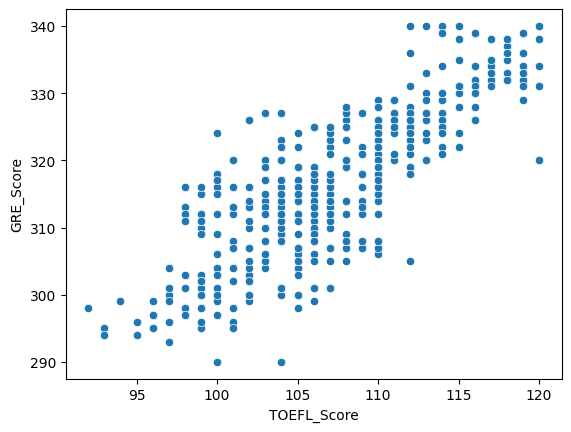

In [111]:
sns.scatterplot(data=data, x="TOEFL_Score", y="GRE_Score")

In [112]:
data.corr()

,Serial_No.,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
Serial_No.,1.000000,-0.097526,-0.147932,-0.169948,-0.166932,-0.088221,-0.045608,-0.063138,0.042336
GRE_Score,-0.097526,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.580391,0.802610
TOEFL_Score,-0.147932,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.489858,0.791594
University_Rating,-0.169948,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.447783,0.711250
SOP,-0.166932,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.444029,0.675732
LOR,-0.088221,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.396859,0.669889
CGPA,-0.045608,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.521654,0.873289
Research,-0.063138,0.580391,0.489858,0.447783,0.444029,0.396859,0.521654,1.000000,0.553202
Chance_of_Admit,0.042336,0.802610,0.791594,0.711250,0.675732,0.669889,0.873289,0.553202,1.000000


In [115]:
res = stats.spearmanr(data["TOEFL_Score"], data["GRE_Score"])
res
# Data jsou statisticky významné na 5% hladině významnosti

SignificanceResult(statistic=0.8318602076053343, pvalue=8.038920665153277e-104)

In [116]:
# 2. Krátce okomentujre, co znamená vypočítaná korelace. Je tato korelace vysoká, pozitivní/negativní?
# Vypočítaná korelace je vysoká a pozitivní. Dle Spearmanova koeficientu jsou statisticky 
# významné na 5% hladině významnosti

In [117]:
# 3. Vytvořte korelační graf (sns.regplot) pro vysvětlovanou proměnnou šance na přijetí (Chance of Admit)
# a proměnnou, která je s ní nejvíce korelovaná

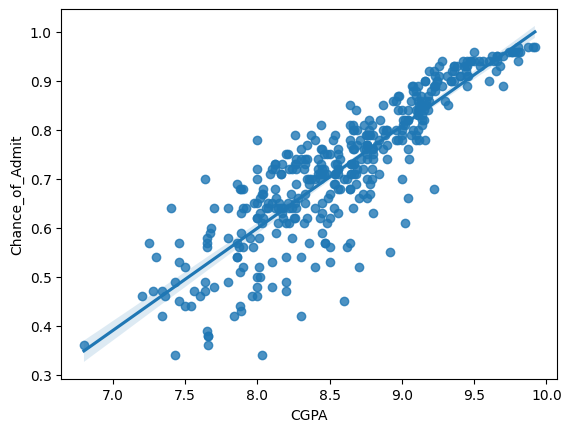

In [118]:
g = sns.regplot(data, x="CGPA", y="Chance_of_Admit")

In [119]:
# Nejvíce korelovaná proměnná s vysvětlovanou proměnnou Chance of Admit je proměnná CGPA. 
# Tato korelace je pozitivní a silná0.873289.

### Vysvětlovaná proměnná

In [120]:
# 1. Vysvětlovanou proměnnou je šance na přijetí (Chance of Admit). Vytvořte boxplot pro tuto proměnnou, 
# aby bylo možné vizuálně identifikovat případné odlehlé hodnoty. 

<AxesSubplot: ylabel='Chance_of_Admit'>

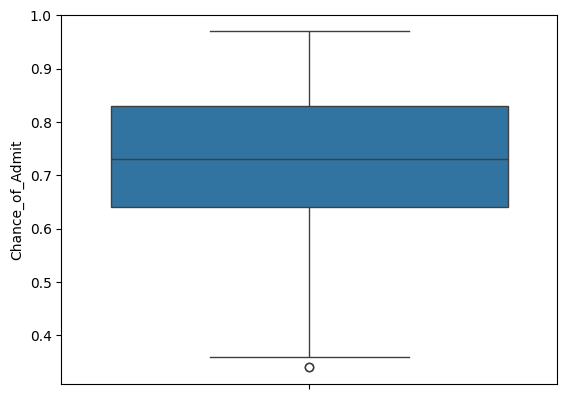

In [121]:
sns.boxplot(data, y="Chance_of_Admit")

In [122]:
iqr(data["Chance_of_Admit"])

0.18999999999999995

In [123]:
q1 = np.percentile(data["Chance_of_Admit"], 25)
q3 = np.percentile(data["Chance_of_Admit"], 75)
iqr = q3 - q1
iqr

0.18999999999999995

In [124]:
# 2. Odstraňte odlehlé pozorování na základě kritérií zjištěných z boxplotu.

In [125]:
data_bez_odlehlych = data[data["Chance_of_Admit"] > 0.19]

<AxesSubplot: ylabel='Chance_of_Admit'>

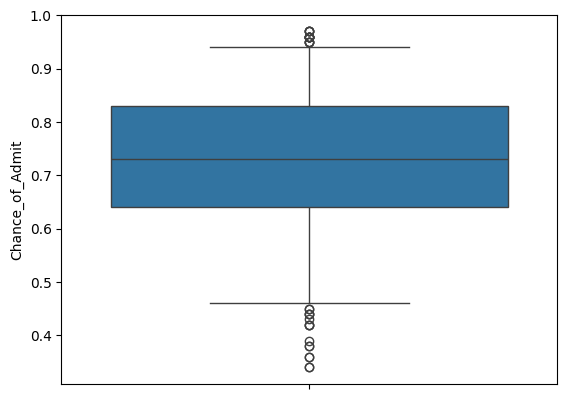

In [126]:
sns.boxplot(data_bez_odlehlych, y="Chance_of_Admit",whis=[5, 95])

### Lineární regrese

In [127]:
#1. Sestavte rovnici pro lineární regresi. Do rovnice zahrňte všechny proměnné, které dávají smysl. 
# Pozor, možná bude potřeba názvy sloupců přejmenovat 

In [128]:
formula = "Chance_of_Admit ~ GRE_Score + TOEFL_Score + University_Rating + SOP + LOR + CGPA + Research"  # vysvětlovaná ~ vysvětlující
mod = smf.ols(formula=formula, data=data_bez_odlehlych) #OLS dělá ordinary least squares 
results = mod.fit() # přímku, který popisuje data 
influence = OLSInfluence(results)
data['Cook Distance'] = influence.cooks_distance[0]
data.head()
#results.summary()

# Zvolila jsem všechny vysvětlující proměnné, které vyšly v korelační tabulce vyšší než 0.5 s Chance of Admit

,Serial_No.,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit,Cook Distance
0,1,337,118,4,4.5,4.5,9.65,1,0.92,0.000423
1,2,324,107,4,4.0,4.5,8.87,1,0.76,0.000771
2,3,316,104,3,3.0,3.5,8.00,1,0.72,0.002327
3,4,322,110,3,3.5,2.5,8.67,1,0.80,0.001616
4,5,314,103,2,2.0,3.0,8.21,0,0.65,0.000090


In [129]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance_of_Admit   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     228.9
Date:                Mon, 13 May 2024   Prob (F-statistic):          3.12e-134
Time:                        15:25:13   Log-Likelihood:                 537.37
No. Observations:                 400   AIC:                            -1059.
Df Residuals:                     392   BIC:                            -1027.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2594      0.125    -10.097      0.000      -1.505      -1.014
GRE_Score             0.0017      0.001      2.906      0.004       0.001       0.003
TOEFL_Score           0.0029      0.001      2.680      0.008       0.001       0.005
University_Rating     0.0057      0.005      1.198      0.232      -0.004       0.015
SOP                  -0.0033      0.006     -0.594      0.553      -0.014       0.008
LOR                   0.0224      0.006      4.034      0.000       0.011       0.033
CGPA                  0.1189      0.012      9.734      0.000       0.095       0.143
Research              0.0245      0.008      3.081      0.002       0.009       0.040
==============================================================================
Omnibus:                       87.895   Durbin-Watson:                   0.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.191
Skew:                          -1.159   Prob(JB):                     4.52e-40
Kurtosis:                       5.344   Cond. No.                     1.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [130]:
# 2. Odhadněte parametry lineárního regresního modelu

In [131]:
# Na odhad parametrů použijeme metodu nejmenších čtverců OLS 


In [132]:
# 3. Interpretujte koeficienty modelu. Které koeficienty jsou statisticky významé? Diskutujte, které proměnné 
# mají největší vliv na šance na přijetí a proč.

# Zde jsou výsledky regresní analýzy pomocí metody nejmenších čtverců (OLS) pro závislou proměnnou "Chance of Admit" (šance na přijetí) 
# Výsledky ukazují, jak GRE Skóre, TOEFL Skóre, hodnocení od univerzity, SOP, LOR, CGPA, a účast na výzkumu ovlivňují šanci na přijetí.
# Model využívá tyto nezávislé proměnné. 

# Charakteristiky modelu jsou:
# R-squared (R²) = 0.803. Model dokáže vysvětlit 80.3% variability v šanci na přijetí na nezávislých proměnných uvedených v tomto modelu.
# Adjusted R-squared (Adj. R²) = 0.800. Upravený koeficient determinace je velmi blízký R². To ukazuje, že model není zatížen nadbytečným počtem proměnných.

# F-statistika = 228.9 s p-hodnotou = 3.12e-134. 
# Model je statisticky významný dle výsledku F-statistiky a nízké p-hodnoty. 
# Alespoň jeden z koeficientů (GRE_Score, TOEFL_Score, University_Rating, SOP, LOR, CGPA, Research) má statisticky významný vliv na šanci na přijetí.

# Koeficienty:
# Intercept(konstanta) je -1.2594 s p-hodnotou < 0.0001. Intercept je statisticky významný.
# GRE_Score: Koeficient 0.0017 říká, že se každým dalším Gre score bodem se šance na přijetí zvyšuje o 0.0017. p = 0.004.
# TOEFL_Score: Koeficient 0.0029 znamená, že se každým dalším bodem z TOEFL se šance na přijetí zvyšuje o 0.0029. p = 0.008.
# University_Rating: Koeficient 0.0057 vypovídá o tom, že se každým dalším bodem od univerzity se šance na přijetí zvyšuje o 0.0057. p = 0.232 
# SOP: Koeficient -0.0033 vyjadřuje, že s každou další změnou o 0.1 SOP se šance na přijetí snižuje o 0.0033. p = 0.553
# LOR: Koeficient 0.0224 sděluje, že s každou další změnou o 0.1 LOR se šance na přijetí zvyšuje o 0.0224. p = 0.000 
# CGPA: Koeficient 0.1189 vyjadřuje, že s každou další změnou o 0.01 CGPA se šance na přijetí zvyšuje o 0.1189. p = 0.000
# Research: Koeficient 0.0245 znamená, že má-li student zkušenost s výzkumem se šance na přijetí zvyšuje o 0.0245. p = 0.002

# Diagnostika reziduí:
# Omnibus test: Výsledek testu je statisticky významný (p < 0.001), což naznačuje, že rezidua nejsou normálně distribuovaná.
# Skew (šikmost) a Kurtosis (špičatost): Hodnoty ukazují, že distribuce reziduí má vyšší špičatost a je více šikmá (v negativním směru) než normální distribuce.


# Zhodnocení modelu a interpretace výsledků

# Model má dobré vysvětlující schopnosti, model dokáže vysvětlit 80.3% variability v šanci na přijetí(dle R-squared hodnoty).
# Jednotlivé koeficienty nejsou příliš významné, ale to se dá pochopit, protože získá-li student 0.1 bodu v jednom z mnoha způsobů hodnocení, tak to ještě 
# nemůže zvýšit šanci o přijetí o desítky procent.
# Z proměnných se dá usuzovat, že CGPA by mohla mít největší vliv na přijetí, protože změna o 0.01 bodu zvyšuje šanci o přijetí o 0.1189.

In [133]:
# 4. Vyhodnoťte kvalitu fitu vašeho lineárního regresního modelu pomocí koeficientu determinace R2.
# Viz předchozí odpověď, kde jsem to popsala

In [134]:
# 5. Vypočítejte Cookovu vzdálenost pro jednotlivé body
# Viz bod #1
data['Cook Distance'] = influence.cooks_distance[0]
data[['Cook Distance']]

,Cook Distance
0,0.000423
1,0.000771
2,0.002327
3,0.001616
4,0.000090
...,...
395,0.000034
396,0.000415
397,0.000001
398,0.001386


<AxesSubplot: xlabel='Cook Distance', ylabel='Count'>

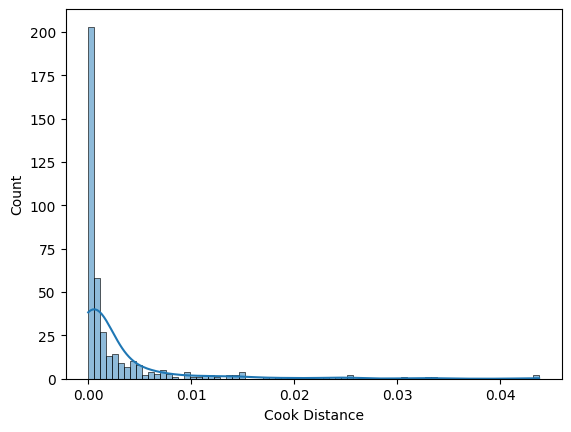

In [135]:
# 6. Vytvořte histogram pro Cookovu zdálenost. Je potřeba nějaké body odstranit, protože by moc ovlivňovali
# naši lineární regresi?
# Můžeme odstranit body nad 1
sns.histplot(data['Cook Distance'], kde=True)

In [136]:
data_modif = data[data['Cook Distance'] < 1] # zobraz jen body menší než 1
mod = smf.ols(formula=formula, data=data_modif)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance_of_Admit   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     228.9
Date:                Mon, 13 May 2024   Prob (F-statistic):          3.12e-134
Time:                        15:25:18   Log-Likelihood:                 537.37
No. Observations:                 400   AIC:                            -1059.
Df Residuals:                     392   BIC:                            -1027.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2594      0.125    -10.097      0.000      -1.505      -1.014
GRE_Score             0.0017      0.001      2.906      0.004       0.001       0.003
TOEFL_Score           0.0029      0.001      2.680      0.008       0.001       0.005
University_Rating     0.0057      0.005      1.198      0.232      -0.004       0.015
SOP                  -0.0033      0.006     -0.594      0.553      -0.014       0.008
LOR                   0.0224      0.006      4.034      0.000       0.011       0.033
CGPA                  0.1189      0.012      9.734      0.000       0.095       0.143
Research              0.0245      0.008      3.081      0.002       0.009       0.040
==============================================================================
Omnibus:                       87.895   Durbin-Watson:                   0.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.191
Skew:                          -1.159   Prob(JB):                     4.52e-40
Kurtosis:                       5.344   Cond. No.                     1.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot: xlabel='Cook Distance', ylabel='Count'>

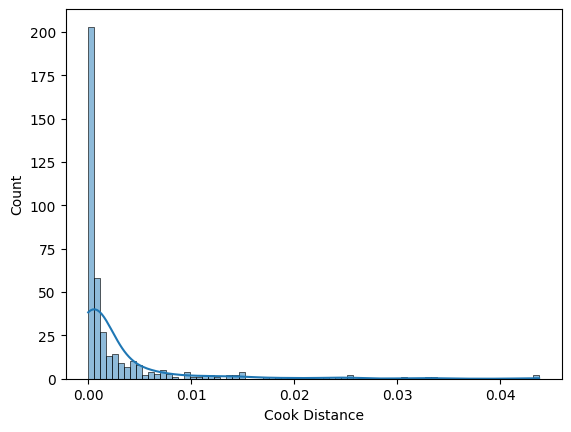

In [137]:
sns.histplot(data_modif['Cook Distance'], kde=True)